### PyTorch CNN Training

PyTorch is a dynamic graph NN library which constructs the graph as you execute and run it as well unlike TF, Caffe, where the graph is specified first and then the same graph is run over and over.

At first thought it might not make sense to use such a framework for traditional CNN usage which majorly involves finetuning from an existing model from the perspective of performance. But It is really useful when it comes to RNN and LSTM where we un roll our graphs based on the input length. We can also do crazy shit even in CNN where we use the same weights and recurrently process the input etc.

PyTorch also has the advantage of being a drop in replacement for numpy with GPU acceleration.

In [4]:
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn # For loss function
from torch.optim import lr_scheduler # Learning rate adjustments

from common import load_dataset, load_model

---
#### Loading data and model

There is this module called torchvision which can be used to load and transform data, use pretrained models. It is very helpful to get started with PyTorch Framework for Deep Learning.

The utility code found in *common.py* helps with loading the model as well as data in our folders as a dataset inside torchvision. It is from the official PyTorch tutorial. The folder structure needs to be as follows for train and val sets.

*Train*
```
 root/train/class1/img1.jpg  
 root/train/class1/img2.jpg  
 ...  
 root/train/class2/img1.jpg  
 ...  
 ...  
``` 
*Val*  
```
root/val/class1/img1.jpg  
 ...  
```


Please check the *common.py* for implementation details. Lets use inception in this example.

For loading the data, we need to know 
 - Architecture (To determine input size)
 - The root directory where our data is kept (as illustrated above)
 - Batch size
 - Number of worker threads
 
The `load_dataset` will return the dataset-dataloader combo for the two phases
 
For the model, we need to pass the 
 - Architecture, 
 - Number of output classes for our problem.
 - Whether to load pretrained model

When we load a pretrained model, it will complain due to mismatch of sizes in the classification layer. I have added the params to the list `conflicted_params` and reinitialized them with random weights. Make sure you don't freeze them while training.

In [2]:
datasets, dataloaders = load_dataset("inception_v3", "./data", batch_size = 32, workers = 4)
model, conflicted_params = load_model("inception_v3", 2, pretrained=True)

/media/hv-titan/Partition2/devil/anaconda2/lib/python2.7/site-packages/torchvision/models/inception.py:65: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  m.weight.data.copy_(values)


=> using pre-trained model 'inception_v3'

--> Ignoring 'AuxLogits.conv0.conv.weight,AuxLogits.conv0.bn.weight,AuxLogits.conv0.bn.bias,AuxLogits.conv0.bn.running_mean,AuxLogits.conv0.bn.running_var,AuxLogits.conv1.conv.weight,AuxLogits.conv1.bn.weight,AuxLogits.conv1.bn.bias,AuxLogits.conv1.bn.running_mean,AuxLogits.conv1.bn.running_var,AuxLogits.fc.weight,AuxLogits.fc.bias' during restore
--> Leaving  'fc.weight,fc.bias' unitialized due to size mismatch / not present in pretrained model


---
#### Training the model

To train any deep learning model we need two things
 - Loss Criterion
 - Optimizer
 
Loss criterion decides how we compute our loss, thereby determining our gradients.
Optimizer helps us take a weight update step based on those gradients.
We can optionally have a learning rate scheduler to change learning rate as the training progresses.

In our experiment, we will use the famous CrossEntropyLoss for Multi Class Classfication, SGD Optimizer and a Step scheduler for learning rate.

In [7]:
# Cross entropy loss between predicted and target
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), 0.01, momentum=0.9, weight_decay=1e-4)

# For every 7 epochs, lr is multiplied by 0.1
scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma=0.1) 

---
#### Running the Training loop

To train the model with the data that we loaded earlier, we need to 
 - Zero out the gradients in the last pass
 - Do a forward pass on the training batch
 - Calculate the loss
 - Do loss.backward() to compute the gradients
 - optimizer.step() to update all the gradients
 
These steps must be repeated for the entire training set. Whenever you run through the entire training set, it is defined as the completion of an *Epoch*. We can run it for as many epochs as we like. The bonus is that for every epoch, the data gets shuffled and transformed differently by the dataset - dataloader combo that we created with torchvision earlier. This is also called data augmentation. This will ensure we don't keep reusing the same samples over and over again in a mini batch and can help avoid over-fitting.

#### Running the Validation Loop

The validation loop is also similar to the training loop, except
 - We don't have to update the weights, so no backward / step
 - We need to measure accuracy - How many classified correctly
 - If the performance is better, we can save this as our "Best model"
 

For every one epoch of training, validation is also performed and we save the model if it is better than our previous one.

All of this is packed into the Experiment Class present in `experiment.py` - partially inspired by Tensorflow Estimator API

For this experiment, lets freeze the remaining part of the net except the classifier layer.

*Warning - If you freeze all the parameters, you won't learn anything and the loss.backward() will complain saying there is nothing to do backward for*

In [11]:
import experiment
reload(experiment)
from experiment import Experiment

for param in model.named_parameters():
    if param[0] not in conflicted_params:
        param[1].requires_grad = False
experiment = Experiment(model, criterion, optimizer, scheduler)


Ready to rock and roll!


In [12]:
NUM_EPOCHS = 2
experiment.train(NUM_EPOCHS, dataloaders)

Epoch 1/2
----------
Phase : train
----------
Epoch: [1] (1/625)	Batch 4.586 (4.586)	Data 1.793 (1.793)	Loss 1.1316 (1.1316)	Prec@1 56.250 (56.250)	
Epoch: [1] (101/625)	Batch 0.158 (0.270)	Data 0.000 (0.086)	Loss 0.2231 (0.5294)	Prec@1 90.625 (81.590)	
Epoch: [1] (201/625)	Batch 0.179 (0.239)	Data 0.018 (0.067)	Loss 0.4823 (0.4154)	Prec@1 78.125 (85.899)	
Epoch: [1] (301/625)	Batch 0.266 (0.224)	Data 0.104 (0.056)	Loss 0.4408 (0.3778)	Prec@1 84.375 (87.552)	
Epoch: [1] (401/625)	Batch 0.170 (0.220)	Data 0.000 (0.053)	Loss 0.2106 (0.3589)	Prec@1 93.750 (88.365)	
Epoch: [1] (501/625)	Batch 0.192 (0.222)	Data 0.022 (0.054)	Loss 0.4573 (0.3500)	Prec@1 90.625 (88.822)	
Epoch: [1] (601/625)	Batch 0.356 (0.226)	Data 0.191 (0.058)	Loss 0.1328 (0.3381)	Prec@1 93.750 (89.242)	
Epoch: [1] (625/625)	Batch 0.684 (0.230)	Data 0.519 (0.061)	Loss 0.8125 (0.3355)	Prec@1 71.875 (89.320)	
Throughput : 139.338723956
Total time for Phase "train"in Epoch 1 : 143.545543
Phase : val
----------
Epoch: [1] (1/

---
#### Prediction

For prediction we can still use the same dataset-dataloader to load our dataset and run the model over each input and get a predicted output. Since we don't need the backward pass for this case, we can set the input Variable to `volatile`. This will affect every other variable involved along with this variable in the graph and makes sure there is no gradient computed. By setting it on the input, we are ensuring nothing gets backpropagated.

Steps for prediction
 - Use the dataset-dataloader with the necessary scaling / normalization transform
 - Call predict with the current or the best model
 
This is also wrapped inside the Experiment class. You can call the `predict` method with the dataloader and optionally the model checkpoint to load from. We usually load the best checkpoint for submission

The outputs of this method will be the predictions and the probabilities.

In [19]:
import torchvision.transforms as transforms
import torchvision.datasets as dsets

data_transform = transforms.Compose([
            transforms.Scale(299),
            transforms.CenterCrop(299),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
testset = dsets.ImageFolder('./data/test', data_transform) 
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=32,
                                         shuffle=False,
                                         pin_memory=True,
                                         num_workers=4)


preds, probs = experiment.predict(testloader, './model_best.pth')

=> loading checkpoint './model_best.pth'
Prediction Throughput (images/sec) : 215.622629504


In [20]:
print(preds.shape, probs.shape)

((12500,), (12500, 2))


Wait, But we dont know which one is what. What does '1' mean - Is it a cat or a dog?

To relieve you of this confusion, the dataset has a class-to-index mapping. You can invert the map and get the classnames as follows.

In [21]:
classess = datasets["train"].classes
class_to_idx = datasets["train"].class_to_idx
idx_to_class = {v:k for k,v in class_to_idx.iteritems()}

# Lets look at first 10 predictions
for i in range(10):
    print("Image {} : {}".format(i + 1, idx_to_class[preds[i]]))

Image 0 : dog
Image 1 : dog
Image 2 : dog
Image 3 : dog
Image 4 : cat
Image 5 : cat
Image 6 : cat
Image 7 : cat
Image 8 : cat
Image 9 : cat


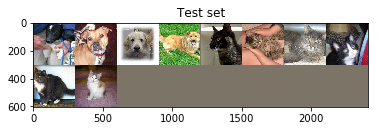

In [25]:
# Lets have a look at the images too
import matplotlib.pyplot as plt
import torchvision
import numpy as np
plt.ion()

# Copied from pytorch tutorials
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
inputs, _ = next(iter(testloader))
out = torchvision.utils.make_grid(inputs[:10])
imshow(out, title="Test set")

---
### That's all folks

**Credits**

 - Thanks to the PyTorch team for their incredible tutorials, documentation and support in the Forum
 
 
**References and Citations**

 - https://github.com/ahirner/pytorch-retraining (inspiration)
 - http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
 - http://pytorch.org/docs/master/index.html